# Import

In [8]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
from datetime import datetime
import os
import pathlib
import matplotlib.pyplot as plt

# 1. Load Data

In [9]:
# Create a list to add csv files as df
Bldg = []

# Read all building data and append to list
for path in pathlib.Path("..microclimate_model/Combined/dataset2").iterdir():
        if path.is_file():
            current_file = pd.read_csv(path)
            current_file = current_file.drop(columns=['Unnamed: 0'])
            Bldg.append(current_file)
    

## 1.1 Preprocessing 

1. Adding Month, Hour, and Minute to data
2. Removing hours out of ENVI-met accuracy range (after 9 pm)
3. Add CHWTON/SQFT to columns using condition area for each building taken from
    https://fdm-apps.asu.edu/UFRM/FDS/FacilityData.aspx

In [10]:
# Create Month, Hour, and Minute column for all dataframes in list
for i in range(len(Bldg)):
    Bldg[i].Date_Time = pd.to_datetime(Bldg[i].Date_Time)
    Bldg[i]['Month_num'] = Bldg[i].Date_Time.dt.month
    Bldg[i]['Hour_num'] = Bldg[i].Date_Time.dt.hour
    Bldg[i]['Minute_num'] = Bldg[i].Date_Time.dt.minute

# Remove data after 9pm
for i in range(len(Bldg)):
    Bldg[i] = Bldg[i][(Bldg[i]['Hour_num'] <= 20) & (Bldg[i]['Hour_num'] > 0)]

# Add Column: CHWTON/Condition Area (SqFt) or ['CHWTON/SQFT']
cond_area = {'Noble Library':88658,'Biodesign B':132215,'Biodesign C':145410,
             'Biodesign A':133016,'Psychology':69864,'Goldwater':165237,'Schwada COB':99857,
             'ISTB 2':41404,'Bulldog Hall':68067,'ISTB 4':231646,'Psychology North':43034}
for i in range(len(Bldg)):
    if Bldg[i]['bldgname'][0] in cond_area:
        Bldg[i]['CHWTON/SQFT'] = Bldg[i]['CHWTON'] / cond_area[Bldg[i]['bldgname'][0]]

<ipython-input-10-5ea8a359b387>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Bldg[i]['CHWTON/SQFT'] = Bldg[i]['CHWTON'] / cond_area[Bldg[i]['bldgname'][0]]


# 2. Single Building

## 2.1 Select Building

In [11]:
# Ask user to select building
for i in range(len(Bldg)):
    print(i, Bldg[i]['bldgname'][0])

bldgnum = int(input("Enter the number of the building from the list above: "))

Bldg[bldgnum].head()

0 Noble Library
1 Biodesign B
2 Biodesign C
3 Biodesign A
4 Psychology
5 Goldwater
6 Schwada COB
7 ISTB 2
8 Bulldog Hall
9 ISTB 4
10 Psychology North
Enter the number of the building from the list above: 1


,bldgname,Date,Time,Air Temp,Rel Hum,KW,CHWTON,HTmmBTU,Date_Time,Month_num,Hour_num,Minute_num,CHWTON/SQFT
0,Biodesign B,2018-05-16,05:00,24.040925,20.616757,457.98,334.01,0.58,2018-05-16 05:00:00,5,5,0,0.002526
1,Biodesign B,2018-05-16,05:15,24.220021,23.379832,461.70,260.40,0.62,2018-05-16 05:15:00,5,5,15,0.001970
2,Biodesign B,2018-05-16,05:30,24.054303,23.070921,458.10,268.27,0.62,2018-05-16 05:30:00,5,5,30,0.002029
3,Biodesign B,2018-05-16,05:45,23.935568,23.126250,466.81,271.76,0.61,2018-05-16 05:45:00,5,5,45,0.002055
4,Biodesign B,2018-05-16,06:00,23.808253,23.394283,455.00,270.87,0.58,2018-05-16 06:00:00,5,6,0,0.002049


In [13]:
# Check dates in data
Bldg[bldgnum]['Date'].unique()

array(['2018-05-16', '2018-05-23', '2018-06-07', '2018-06-08',
       '2018-06-20', '2018-06-21', '2018-08-03', '2018-09-11',
       '2018-09-29'], dtype=object)

## 2.2 EDA

### 2.2.1 Boxplots

0 bldgname
1 Date
2 Time
3 Air Temp
4 Rel Hum
5 KW
6 CHWTON
7 HTmmBTU
8 Date_Time
9 Month_num
10 Hour_num
11 Minute_num
12 CHWTON/SQFT
Enter the number of the following data columns to graph boxplot: 12

 Biodesign B CHWTON/SQFT for each hour for all days in data.


<AxesSubplot:title={'center':'CHWTON/SQFT'}, xlabel='Hour_num'>

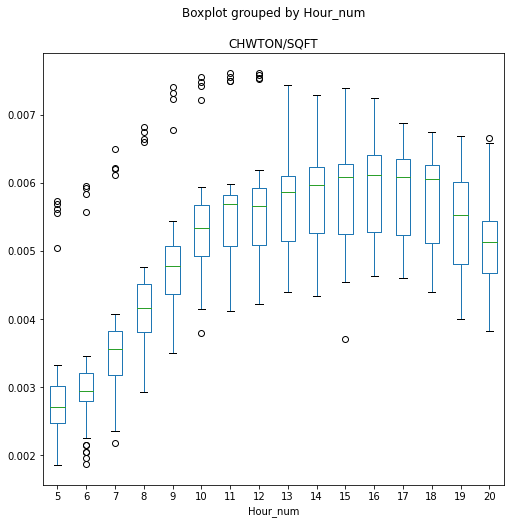

In [15]:
# Show df columns to select for boxplot
x = Bldg[bldgnum].columns
for i in range(len(x)):
    print(i, x[i])
# Get column name from user
colname = int(input("Enter the number of the following data columns to graph boxplot: "))
# Plot
print('\n',Bldg[bldgnum]['bldgname'][0], "CHWTON/SQFT for each hour for all days in data.")
Bldg[bldgnum].boxplot(by='Hour_num', column=x[colname], grid = False, figsize = (8,8))


### 2.2.2 Time Series

Month available:<br>
May: 16, 23 <br>
June: 7, 8, 20, 21, 25<br>
August: 3<br>
September: 11, 29<br>

Enter month number: 5

 2 day(s) found in May 

0 bldgname
1 Date
2 Time
3 Air Temp
4 Rel Hum
5 KW
6 CHWTON
7 HTmmBTU
8 Date_Time
9 Month_num
10 Hour_num
11 Minute_num
12 CHWTON/SQFT
Enter y-axis from column list above: 12


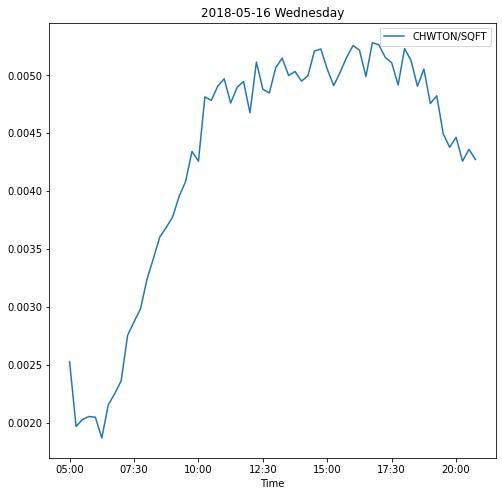

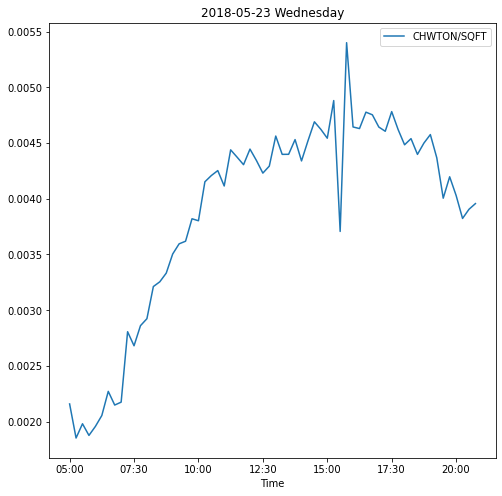

In [17]:
import datetime
# Get month number for plotting
m_num = int(input("Enter month number: "))
# Convert to datetime to get month name
datetime_object = datetime.datetime.strptime(str(m_num), "%m")
m_name = datetime_object.strftime("%b")

# Plot only if entered month is in data
if m_num in Bldg[bldgnum]['Month_num'].unique():
    from datetime import datetime
    # Assign new df for chosen month
    plotdf = pd.DataFrame(Bldg[bldgnum][(Bldg[bldgnum]['Month_num'] == m_num)])
    # Show number of days found in chosen month
    x = plotdf['Date'].unique()
    print("\n", len(x), "day(s) found in", m_name, "\n")
    # Show all columns to select y-axis for plotting
    cols = plotdf.columns
    for i in range(len(cols)):
        print(i, cols[i])
    # Get y-axis for plotting
    y_ax = int(input('Enter y-axis from column list above: '))
    y_ax = cols[y_ax]
    for i in range(len(x)):
        datetime_object = datetime.strptime(x[i], '%Y-%m-%d')
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
        d = days[datetime_object.weekday()]
        plotdf1 = plotdf[(plotdf['Date']==x[i])]
        plotdf1.plot(x = 'Time', y = y_ax, grid = False, figsize = (8,8), title = x[i] + ' ' + d)
else:
    print("Month number not in data")

##### 2.2.3 Correlation Matrix

<AxesSubplot:>

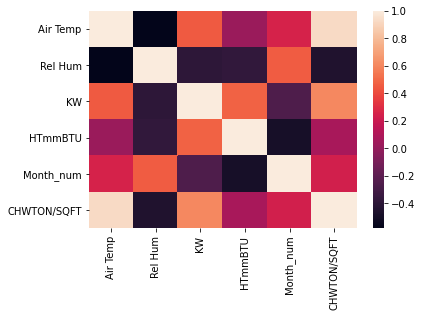

In [18]:
corr_pd = pd.DataFrame(Bldg[bldgnum][['Time','Air Temp','Rel Hum','KW','HTmmBTU','Month_num', 'CHWTON/SQFT']])
corrMatrix = corr_pd.corr()
sns.heatmap(corrMatrix)


## 2.3 Random Forest without tuning

In [19]:
# drop na values if in dataframe
if (Bldg[bldgnum].isnull().values.any() == True):
    Bldg[bldgnum] = Bldg[bldgnum].dropna()
    
# split data into X and y
X = Bldg[bldgnum].drop(columns=['CHWTON/SQFT','Month_num', 'Date', 'Time','bldgname','HTmmBTU', 'Date_Time', 'CHWTON', 'KW', 'Minute_num'])
y = Bldg[bldgnum]['CHWTON/SQFT']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

# Set up model. Number of trees 100
base_RF = RandomForestRegressor(n_estimators = 100, random_state = 42)

# Train data
base_RF.fit(X_train, y_train)

# Get prediction
y_pred = base_RF.predict(X_test)
ModelPred = pd.DataFrame({'Actual':y_test, 'Predicted':y_pred})
ModelPred = ModelPred.sort_index()
print(ModelPred)

score = base_RF.score(X_test, y_test)
rf_score = pd.DataFrame({"bldgname": Bldg[bldgnum]['bldgname'].unique()[0], "test score (on 20% of data)": [score]})
rf_score

       Actual  Predicted
3    0.002055   0.002124
10   0.002873   0.002879
13   0.003417   0.003430
14   0.003604   0.003521
16   0.003779   0.003993
..        ...        ...
716  0.005129   0.004781
733  0.005269   0.005198
736  0.005219   0.005265
746  0.004907   0.005001
752  0.004760   0.004724

[128 rows x 2 columns]


,bldgname,test score (on 20% of data)
0,Biodesign B,0.969164


# 3. All Buildings

## 3.1 EDA

### 3.1.1 Boxplots

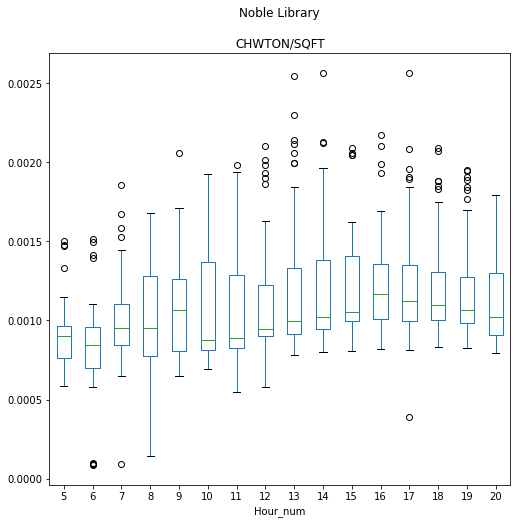

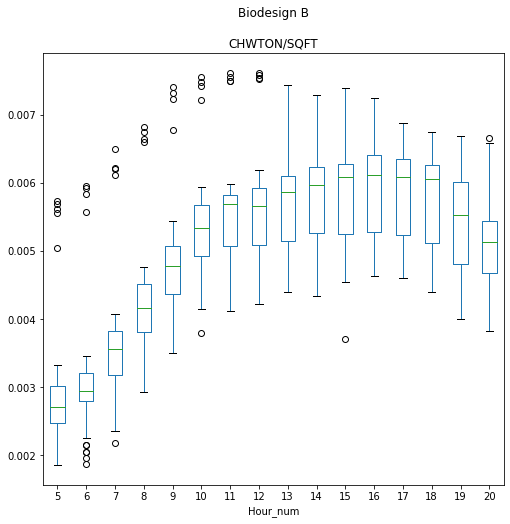

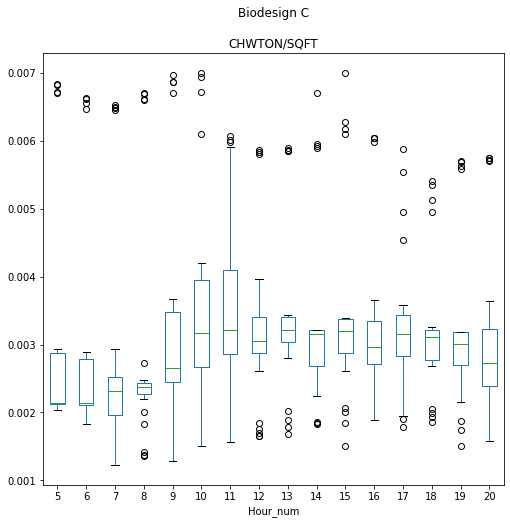

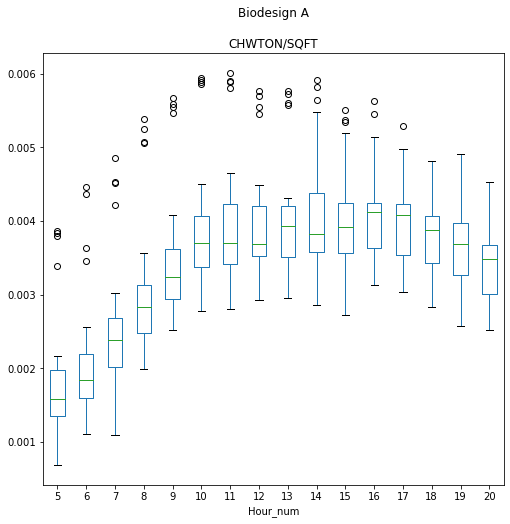

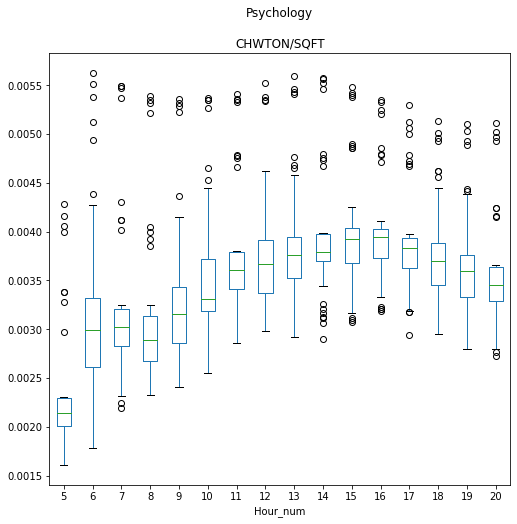

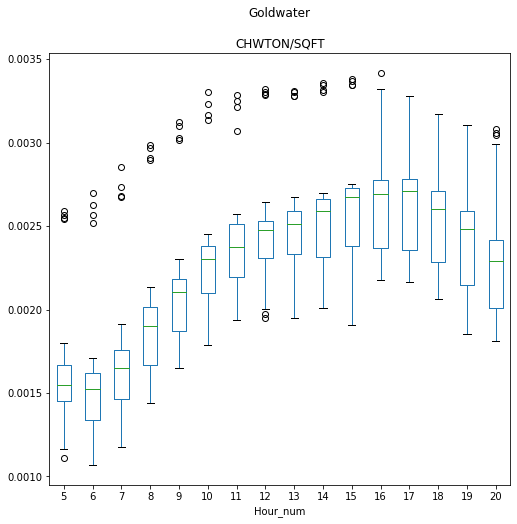

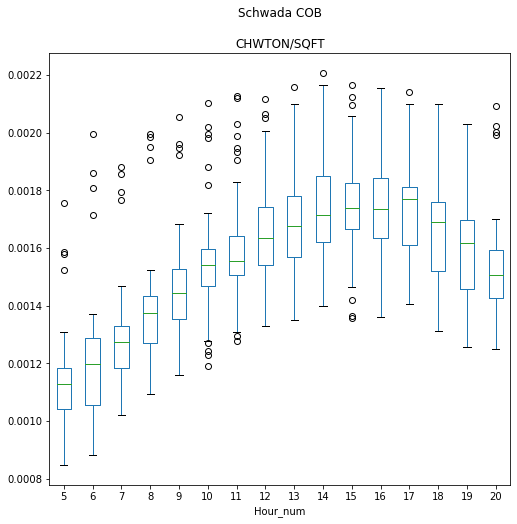

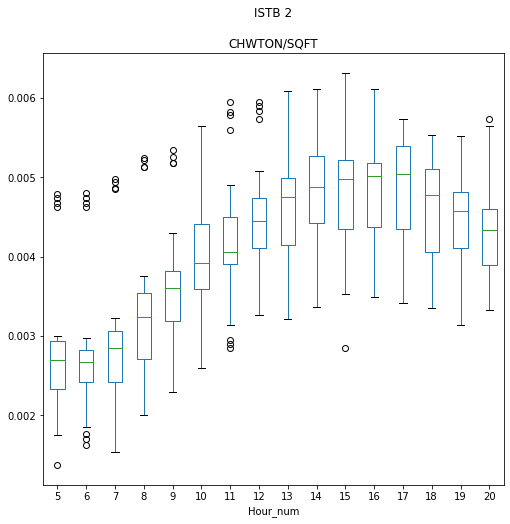

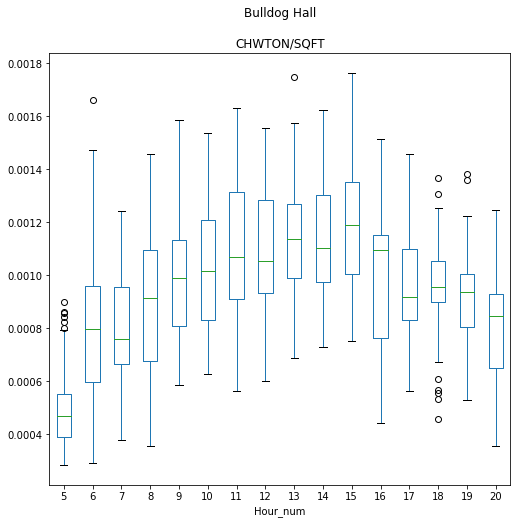

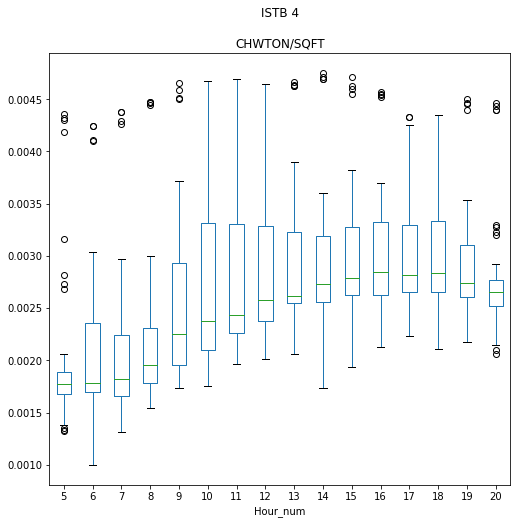

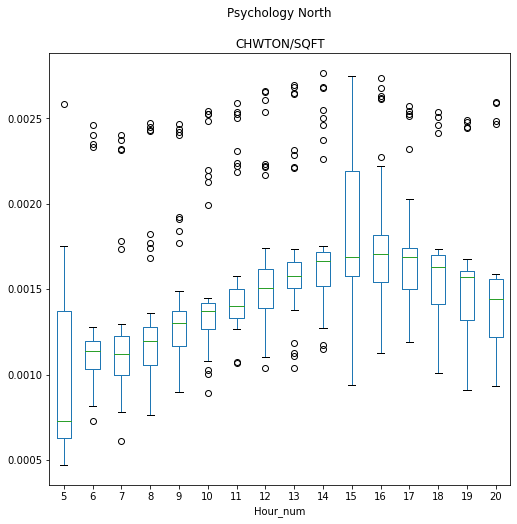

In [20]:
## Print all boxplots for all buildings ##
for i in range(len(Bldg)):
    Bldg[i].boxplot(by='Hour_num', column=['CHWTON/SQFT'], grid = False, figsize = (8,8))
    plt.suptitle(Bldg[i].bldgname[0])


### 3.1.2 Time Series

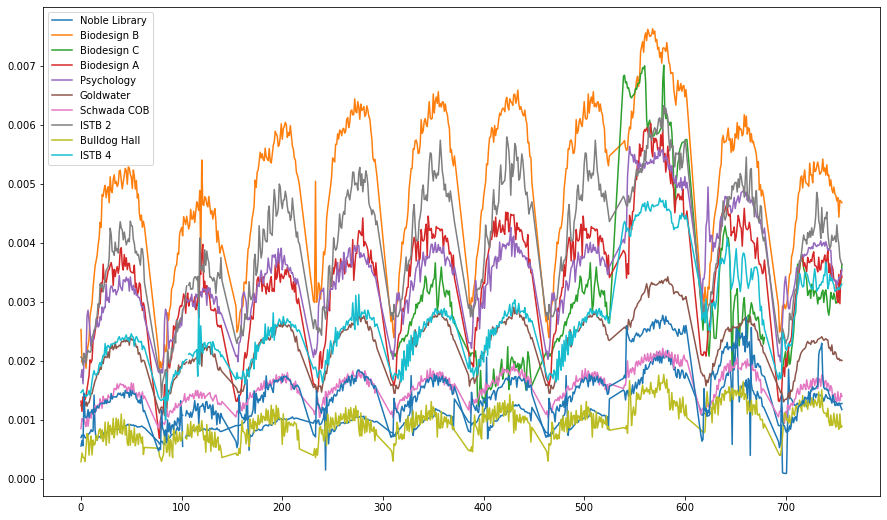

In [21]:
## Print CHWTON/SQFT for all buildings and all timestamps in data
ax = Bldg[0]['CHWTON/SQFT'].plot(figsize = (15,9))
legendlabels = []
for i in range(len(Bldg)-1):
    Bldg[i+1]['CHWTON/SQFT'].plot(ax=ax)
    legendlabels.append(Bldg[i].bldgname[0])
    
ax.legend(labels = legendlabels)


In [22]:
# Bldg[2]['CHWTON/SQFT'].plot(figsize = (15,9))
# plt.title(Bldg[2].bldgname[0])
# plt.show()

## 3.2 Random Forest without tuning


In [23]:
### Create dataframe and add building names ###
rf_bld_scores = pd.DataFrame(columns = {"bldgname", "test score (on 20% of data)"})
for i in range(len(Bldg)):
    rf_bld_scores = rf_bld_scores.append({'bldgname': Bldg[i]['bldgname'].unique()[0]}, ignore_index=True)
rf_bld_scores.fillna(5)

### Append scores to all buildings ###

for i in range(len(Bldg)):
    
    # drop na values if in dataframe
    if (Bldg[i].isnull().values.any() == True):
        Bldg[i] = Bldg[i].dropna()
        
    # split data into X and y
    X = Bldg[i].drop(columns=['Date', 'Time','bldgname','HTmmBTU', 'Date_Time', 'CHWTON', 'KW', 'CHWTON/SQFT'])
    y = Bldg[i]['CHWTON']
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
    
    # Set up model. Number of trees 100
    base_RF = RandomForestRegressor(n_estimators = 100, random_state = 42)

    # Train data
    base_RF.fit(X_train, y_train)

    # Get prediction
    y_pred = base_RF.predict(X_test)
    ModelPred = pd.DataFrame({'Actual CHWTON':y_test, 'Predicted CHWTON':y_pred})
    ModelPred = ModelPred.sort_index()
    
    # Save scores
    score = base_RF.score(X_test, y_test)
    rf_bld_scores['test score (on 20% of data)'][i] = score
    
rf_bld_scores

,bldgname,test score (on 20% of data)
0,Noble Library,0.819227
1,Biodesign B,0.969212
2,Biodesign C,0.948762
3,Biodesign A,0.958112
4,Psychology,0.944052
5,Goldwater,0.972076
6,Schwada COB,0.90722
7,ISTB 2,0.970365
8,Bulldog Hall,0.689621
9,ISTB 4,0.96989
